
# CTF: Contrast Transfer Function

This tutorial demonstrates the CTF and corresponds to
lecture notes from MATH586 at Princeton.


In [ ]:
# Get some common imports out of the way.
import os
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt

plt.rcParams["image.cmap"] = "gray"
import numpy as np
from scipy.ndimage import gaussian_filter

import aspire

# Image size to use throughout the demo.
IMG_SIZE = 512

## Visualizing the CTF
ASPIRE can be used to create and visualize example CTFs.



### Radially Symmetric CTF
The ``RadialCTFFilter`` is used to create a radially symmetric
``Filter`` object for use with ASPIRE.
This object can also be used to calculate the transfer function as a numpy array.



In [ ]:
from aspire.image import Image
from aspire.operators import CTFFilter, RadialCTFFilter

radial_ctf_filter = RadialCTFFilter(
    voltage=200,  # kV
    defocus=10000,  # angstrom, 10000 A = 1 um
    Cs=2.26,  # Spherical aberration constant
    alpha=0.07,  # Amplitude contrast phase in radians
    B=0,  # Envelope decay in inverse square angstrom (default 0)
)

# The CTF filter can be visualized as an image once it is evaluated at a specific resolution.
# More specifically the following code will return a transfer function as an array,
# which is then plotted.
rctf_fn = radial_ctf_filter.evaluate_grid(IMG_SIZE, pixel_size=1)
plt.imshow(rctf_fn)
plt.colorbar()
plt.show()

### Elliptical CTF
For the general ``CTFFilter``,
we provide defocus along two perpendicular axes u and v separately,
along with the angle the u-axis makes with the horizontal (x) axis.
Note that we chose an extreme astigmatism for demonstration,
and the values more typically differ by a few percent.



In [ ]:
ctf_filter = CTFFilter(
    voltage=200,  # kV
    defocus_u=15000,  # angstrom, 10000 A = 1 um
    defocus_v=10000,
    defocus_ang=np.pi / 6,  # Radians
    Cs=2.26,  # Spherical aberration constant
    alpha=0.07,  # Amplitude contrast phase in radians
    B=0,  # Envelope decay in inverse square angstrom (default 0)
)

# Again, we plot it, and note the difference from the RadialCTFFilter.
plt.imshow(ctf_filter.evaluate_grid(IMG_SIZE, pixel_size=1))
plt.colorbar()
plt.show()

### Phase Flipping
A common technique used with CTF corrupted data is to apply a transformation
based on the sign of the (estimated) CTF.
We can easily visualize this in an idealized way by taking the sign of the
array returned by ASPIRE's ``CTFFilter.evaluate_grid``.



In [ ]:
ctf_sign = np.sign(radial_ctf_filter.evaluate_grid(IMG_SIZE, pixel_size=1))
plt.imshow(ctf_sign)
plt.colorbar()
plt.show()

## Applying CTF Directly to Images
Various defocus values and phase flipping correction will be
applied directly to images using a mix of ASPIRE and Numpy.



### Generate Example Image



In [ ]:
def generate_example_image(L, noise_variance=0.1):
    """
    Generates data similar to the MATH586 lecture notes.

    :param L: Resolution in pixels.
    :param noise_variance: Variance passed to random normal noise generator.
    :return: Image as np array.
    """
    # Empty Array
    img = np.zeros((L, L))

    # Construct grid
    g2d = aspire.utils.grid_2d(L, normalized=False)

    # Make central square
    img[(np.abs(g2d["x"]) < L // 6) & (np.abs(g2d["y"]) < L // 6)] = 1

    # Remove the outer corners
    disc = g2d["r"] > (1.2 * L // 6)
    img[disc] = 0

    # Remove center circle
    disc = g2d["r"] < L // 24
    img[disc] = 0

    # Smooth hard edges with some Gaussian blur
    img = gaussian_filter(img, sigma=7)

    # Add noise
    img += np.random.normal(0, noise_variance, size=(L, L))

    return img


img = Image(generate_example_image(IMG_SIZE), pixel_size=1)
img.show()

### Apply CTF and Phase Flipping
First, CTF filters for a range of defocus values are created
and used to corrupt the example image.
Then phase flipping will use the actual CTF paramaters to attempt idealized corrections.
ASPIRE has built in tools for performing these tasks which are discussed towards the end,
but here the methods are demonstrated directly.



In [ ]:
# Construct a range of CTF filters.
defoci = [2500, 5000, 10000, 20000]
ctf_filters = [
    RadialCTFFilter(voltage=200, defocus=d, Cs=2.26, alpha=0.07, B=0) for d in defoci
]

#### Generate CTF corrupted Images
Generate images corrupted by progressively increasing defocus.



In [ ]:
# For each defocus, apply filter to the base image.
imgs = Image(np.empty((len(defoci), IMG_SIZE, IMG_SIZE)), pixel_size=1)
for i, ctf in enumerate(ctf_filters):
    imgs[i] = img.filter(ctf)[0]
imgs.show()

#### Generate Phase Flipped Images



In [ ]:
# Construct the centered 2D FFT of the images.
imgs_f = aspire.numeric.fft.centered_fft2(imgs)

# Manually apply phase flipping transformation.
phase_flipped_imgs_f = np.empty_like(imgs_f)
for i, ctf in enumerate(ctf_filters):
    # Compute the signs of this CTF
    # In practice, this would be an estimated CTF,
    # but in the demo we have the luxury of using the model CTF that was applied.
    signs = np.sign(ctf.evaluate_grid(IMG_SIZE, pixel_size=1))
    # Apply to the image in Fourier space.
    phase_flipped_imgs_f[i] = signs * imgs_f[i]

# Construct the centered 2D FFT of the images.
phase_flipped_imgs = aspire.numeric.fft.centered_ifft2(phase_flipped_imgs_f).real
Image(phase_flipped_imgs, pixel_size=1).show()

<div class="alert alert-danger"><h4>Warning</h4><p>Centering the signal FFT is critical when the CTF is centered in Fourier space.</p></div>



## Validating ``CTFFilter``
The forward modeling of CTF can be validated by passing a corrupted image
through CTF estimators and comparing the resulting defocus value(s).



### Importance of correct CTF Estimation
Phase flipping with incorrect CTF estimates can further corrupt signal.
Here we plot a ray of the ``radial_ctf_filter`` modeled earlier,
along with an erroneous CTF filter.



In [ ]:
bad_est_ctf_filter = RadialCTFFilter(
    voltage=200,
    defocus=14000,  # Modeled CTF was 10000
    Cs=2.26,
    alpha=0.07,
    B=0,
)
# Evaluate Filter, returning a Numpy array.
bad_ctf_fn = bad_est_ctf_filter.evaluate_grid(IMG_SIZE, pixel_size=1)

c = IMG_SIZE // 2 + 1
plt.plot(rctf_fn[c, c:], label="Model CTF")  # radial_ctf_filter
plt.plot(bad_ctf_fn[c, c:], label="Incorrect CTF Estimate")
plt.legend()
plt.show()

Compare the idealized CTF phase flipping correction
with phase flipping an incorrect CTF.



In [ ]:
idealized_flipped_fn = rctf_fn * np.sign(rctf_fn)
incorrect_flipped_fn = rctf_fn * np.sign(bad_ctf_fn)
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.suptitle("Application of Phase Flipping")
ax1.plot(idealized_flipped_fn[c, c:])
ax1.set_title("Idealized")
ax2.plot(incorrect_flipped_fn[c, c:])
ax2.set_title("Incorrect")
plt.show()

### ASPIRE CtfEstimator
Here we will use ASPIRE's ``CtfEstimator`` on a CTF corrupted image
so we can compare with the modeled corruption parameters.



In [ ]:
from aspire.ctf import estimate_ctf

# Using our radial_ctf_filter from earlier, corrupt an image.
test_img = img.filter(radial_ctf_filter)
test_img.show()

# Create the image file in a tmp dir
with TemporaryDirectory() as d:
    test_img.save(os.path.join(d, "test_img.mrc"))

    radial_ctf_est = estimate_ctf(
        data_folder=d,
        pixel_size=1,
        cs=radial_ctf_filter.Cs,
        amplitude_contrast=radial_ctf_filter.alpha,
        voltage=radial_ctf_filter.voltage,
        psd_size=512,
        num_tapers=2,
        dtype=np.float64,
    )

# We'll use these estimates next.
print(radial_ctf_est)

### Using ASPIRE's CTF Estimate
Previously we computed some radial CTF estimates in ``radial_ctf_est``.
Here we will view the application of these estimates in phase flipping
our example image.



In [ ]:
# Get the relevant estimate.
est = radial_ctf_est["test_img.mrc"]

# Take an average defocus for radial case.
defocus = (est["defocus_u"] + est["defocus_v"]) / 2.0
print(f"defocus = {defocus}")

# Create a filter and evaluate.
est_ctf = RadialCTFFilter(
    voltage=est["voltage"],
    defocus=defocus,  # Modeled CTF was 10000
    Cs=est["cs"],
    alpha=est["amplitude_contrast"],
    B=0,
)
est_ctf_fn = est_ctf.evaluate_grid(IMG_SIZE, pixel_size=1)

# Compare the model CTF with the estimated CTF.
c = IMG_SIZE // 2 + 1
plt.plot(rctf_fn[c, c:], label="Model CTF")
plt.plot(est_ctf_fn[c, c:], label="Estimated CTF")
plt.legend()
plt.show()

Compare the idealized CTF phase flipping correction
with phase flipping the estimated CTF.



In [ ]:
estimated_flipped_fn = rctf_fn * np.sign(est_ctf_fn)
plt.title("Application of estimated CTF Phase Flipping")
plt.plot(estimated_flipped_fn[c, c:])
plt.show()

<div class="alert alert-info"><h4>Note</h4><p>At the time of writing, elliptical CTF estimation is under going development and validation.</p></div>



## ASPIRE Sources: CTF and Phase Flipping
The most common uses of CTF simulation and correction are
implemented behind the scenes in ASPIRE's Source classes.
For simulations, users are expected to provide their own
reasonable CTF parameters. When in doubt they should refer to
EMDB or EMPIAR for related datasets that may have CTF estimates.
ASPIRE also commonly uses some reasonable values for the 10028 dataset
in examples.



### Simulation Source
The following code demonstrates adding the previous list of
CTFs to a Simulation and performing phase flipping.
No calculations beyond defining the CTF parameters are required.



In [ ]:
from aspire.source import Simulation

# Create the Source.  ``ctf_filters`` are re-used from earlier section.
src = Simulation(L=64, n=4, unique_filters=ctf_filters, pixel_size=1)
src.images[:4].show()

Phase flip the images.



In [ ]:
src = src.phase_flip()
src.images[:4].show()

Compare corrupted and phase flipped images to those without corruption.



In [ ]:
src.projections[:4].show()

### Beyond Simulations: Experimental Data Sources
When loading experimental data,
CTF parameters in the STAR file should be loaded automatically.



In [ ]:
from aspire.source import RelionSource

# Load an example Relion starfile
src = RelionSource(
    "../data/sample_relion_data.star",
    pixel_size=1.338,
    max_rows=10000,
    data_folder="../data",
)
src = src.downsample(64)  # easier to visualize
src.images[:3].show()

# Phase flip
src = src.phase_flip()
src.images[:3].show()

## CTFFIND4: External Validation
CTFFIND4 is often used by other cryo-EM distributions,
and was used to confirm the forward CTF filter model of ASPIRE.
For transparency, an example run using the ``test_img.mrc``
generated earlier is documented.

CTFFIND4 estimated 9982.5, within 0.2% of the modeled defocus=10000
for the radially symmetric case.




Interactive session

.. literalinclude:: ../../../../gallery/tutorials/data/ctffind4/input.txt





Diagnostic Output Text

.. literalinclude:: ../../../../gallery/tutorials/data/ctffind4/diagnostic_output.txt





CTFFIND4 Diagnostic Output PDF (rendering of diagnostic_output_avrot.pdf).

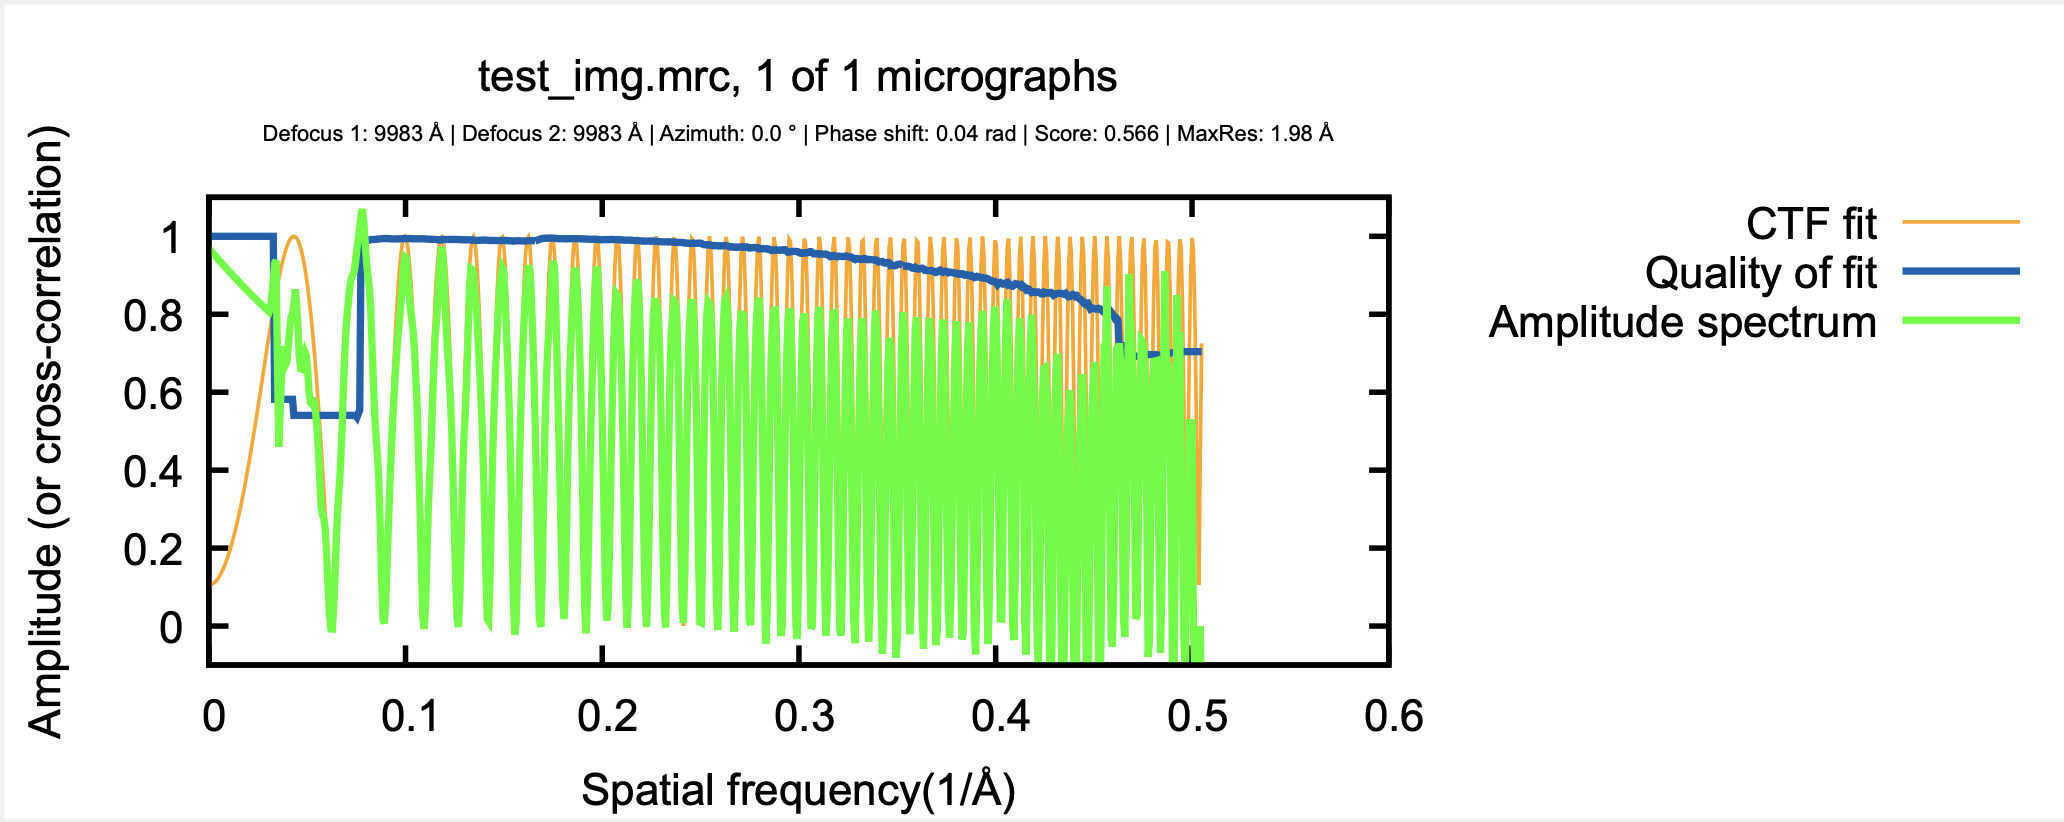




CTFFIND4 Diagnostic Output MRC (rendering of diagnostic_output.mrc).

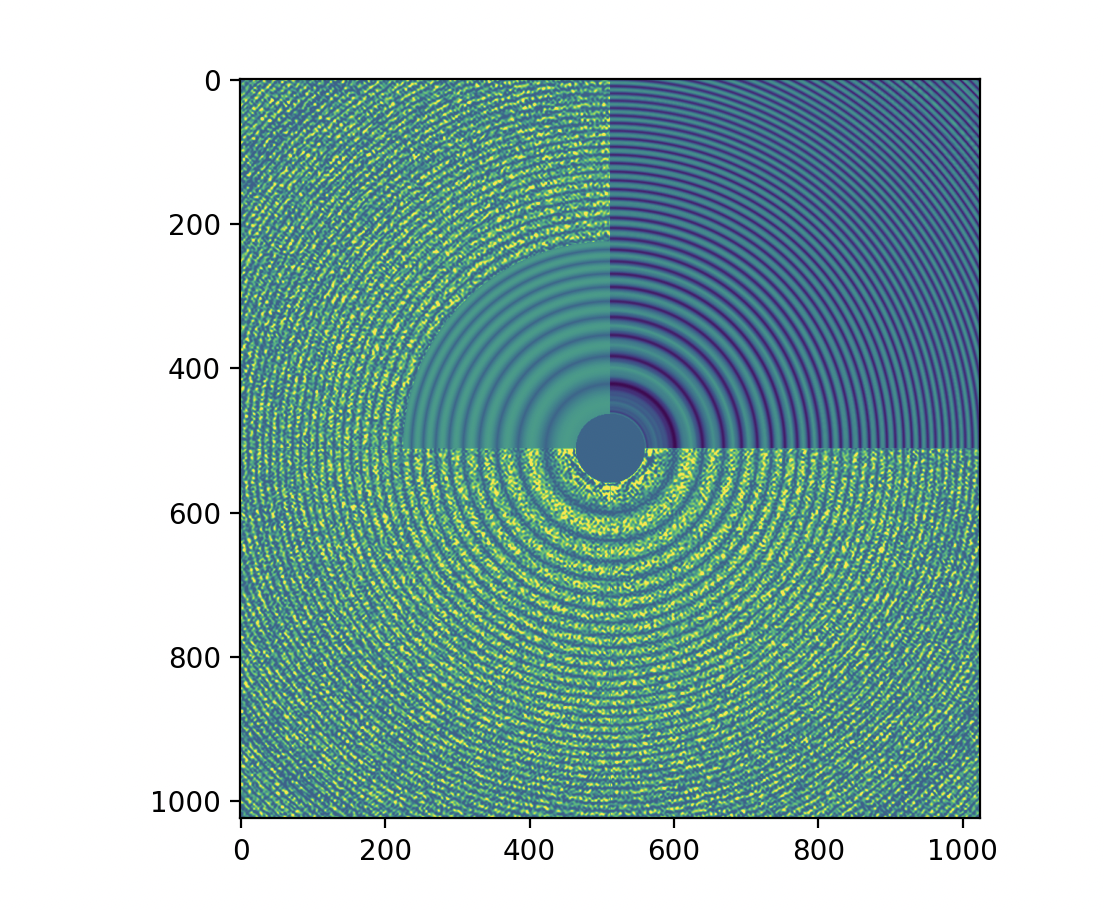


